In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
plt.style.use('../../cross_validation/meyers_latex.mplstyle')
import numpy as np
from scipy.interpolate import interp1d
from scipy.stats import norm
from tqdm import tqdm
import westley

# Create a fake signal in the *frequency domain*

Instead of creating a fake signal in the time domain (like you did using pyGWB), we'll create a fake signal in the frequency domain.

29.4732213041364


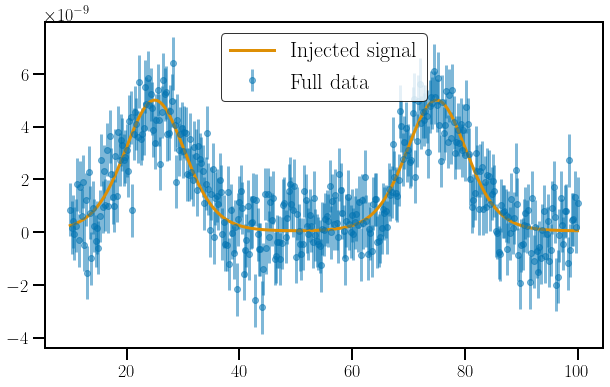

In [5]:
fmin = 10
fmax = 100
df = 0.25

frequencies = np.arange(fmin, fmax+df/2, df)

# Uncertainty on our data points
sigmas = 1e-9 * np.ones(frequencies.size)
# A weird looking model. Weird because we want our fitter to be generic
signal = 5e-10 * 10**(np.cos(4 * np.pi * frequencies / fmax + np.pi))

noise = np.random.randn(frequencies.size) * sigmas
data = signal + noise
plt.ylabel('\hat C(f)')
plt.errorbar(frequencies, data, yerr=sigmas, fmt='o', alpha=0.5, label='Full data')
plt.plot(frequencies, signal, label='Injected signal')
# plt.plot(frequencies, signal2)
plt.legend()
final_pte = np.sum(data * sigmas**-2) / np.sum(sigmas**-2)
final_sig = np.sum(sigmas**-2)**-0.5
print(final_pte / final_sig)

In [12]:
# "Single baseline interpolating model" means that we have a single baseline,
# in this case Hanford and Livingston, and we have some model for the
# C(f) spectrum that is "intrinsic" to hanford and livingston.
# For now, we'll have no magnetic noise in the HL baseline. So we won't even try to model it.
# So we set "max knots" to zero.
sbim = westley.SingleBaselineInterpolatingModel(data, sigmas, frequencies,
                                                min_knots=0, max_knots=0, baseline='HL')
ampdict = {}
ampdict['HL'] = np.zeros(2)

# Multi-baseline correlated model means that we have multiple baselines, and we have a 
# Correlated signal that is in all baselines (the GW spectrum)

# Here, though, we just have 1 baseline -- Hanford and Livingston.
mbim = westley.MultiBaselineInterpolatingModel([sbim], ampdict,
                                               common_signal_max_knots=20,
                                               common_signal_min_knots=0)

sampler = westley.Sampler(mbim)

out = sampler.sample(niter=1000000, thin=10, burn=0.5)


 25%|██▌       | 251054/1000000 [00:39<02:03, 6076.99it/s]

adding birth and death proposals


100%|██████████| 1000000/1000000 [02:39<00:00, 6254.08it/s]


In [14]:
vars(out).keys()

dict_keys(['acceptances', 'lls', 'move_types', 'individual_knots', 'individual_amps', 'individual_configs', 'common_knots', 'common_amps', 'common_config', 'Nsamples'])

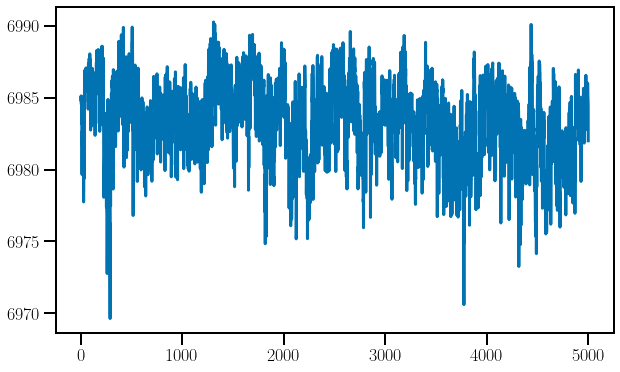

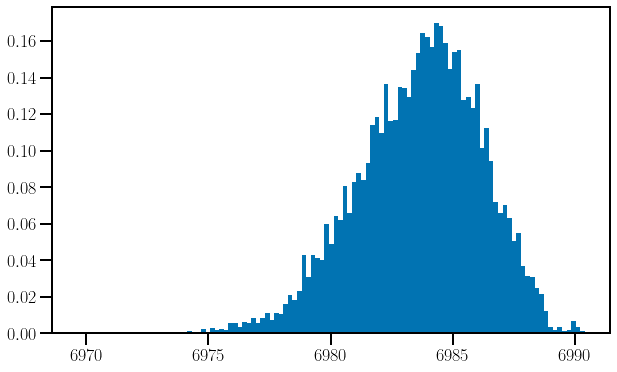

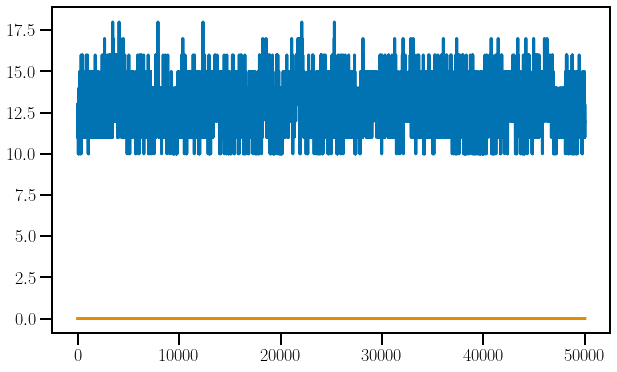

In [27]:
plt.plot(out.lls[::10])
plt.show()

plt.hist(out.lls, density=True, bins='auto')
plt.show()

plt.plot(np.sum(out.common_config, axis=1))
plt.plot(np.sum(out.individual_configs['HL'], axis=1))
plt.show()

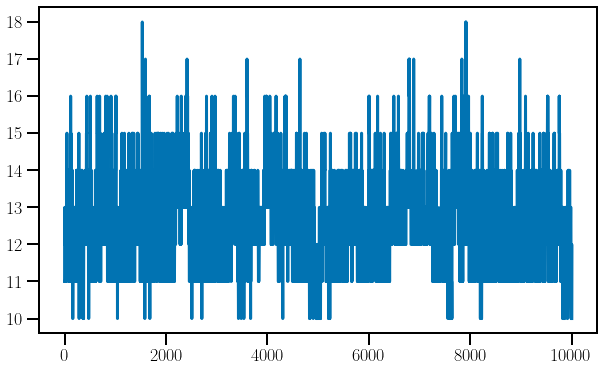

In [8]:
plt.plot(np.sum(out.common_config, axis=1))

In [29]:
def get_dicts_from_idx(ik, ia, ic, idx):
    mydict_knots = {}
    mydict_amps = {}
    mydict_config = {}
    for bl in ik.keys():
        mydict_knots[bl] = ik[bl][idx]
        mydict_amps[bl] = ia[bl][idx]
        mydict_config[bl] = ic[bl][idx]
    return mydict_knots, mydict_amps, mydict_config

7143


<ErrorbarContainer object of 3 artists>

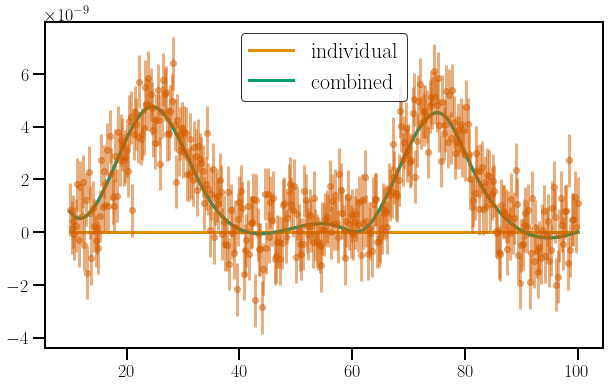

In [31]:
idx = np.random.choice(out.common_config.shape[0])
mylist = get_dicts_from_idx(out.individual_knots, out.individual_amps, out.individual_configs, idx)
print(idx)
im, cm = mbim.evaluate_model(mylist[0], mylist[1], mylist[2], out.common_knots[idx], out.common_amps[idx], out.common_config[idx])
plt.plot(frequencies, np.array(im['HL']) + np.array(cm['HL']))
plt.plot(frequencies, im['HL'], label='individual')
plt.plot(frequencies, cm['HL'], label='combined')
plt.legend()
plt.errorbar(frequencies, data, yerr=sigmas, fmt='o', alpha=0.5)